In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..','..'))
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mlpremier.cnn.preprocess import generate_cnn_data, split_preprocess_cnn_data
from mlpremier.cnn.model import build_train_cnn
import tensorflow as tf


# Run Full Training

======= Generating CNN Data for Season: 2020-21, Position: GK =======
Total players of type GK = 80.
0 players dropped due to low average playtime.
Generated windowed dataframe for CNN of shape: (2527, 3).
Generated combined features dataframe for preprocessing of shape: (2767, 1).

========== Done Generating CNN Data ==========

========== Splitting CNN Data ==========

Shape of windowed_df: (2527, 3)
Shape of a given window (prior to preprocessing): (3, 1)
========== Preprocessing CNN Data ==========

Mean of Standard Scaler:
[1.03794724]

Standard Deviation of Standard Scaler:
[2.2840418]
Transforming features using StandardScaler + OHE Pipeline.
========== Done Preprocessing CNN Data ==========

========== Done Splitting CNN Data ==========

====== Building CNN Architecture ======
====== Done Building CNN Architecture ======
Epoch 1/200
45/45 [==============================] - 0s 2ms/step - loss: 4.5581 - mae: 0.9633 - val_loss: 10.6101 - val_mae: 1.9264
Epoch 2/200
45/45 [========

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


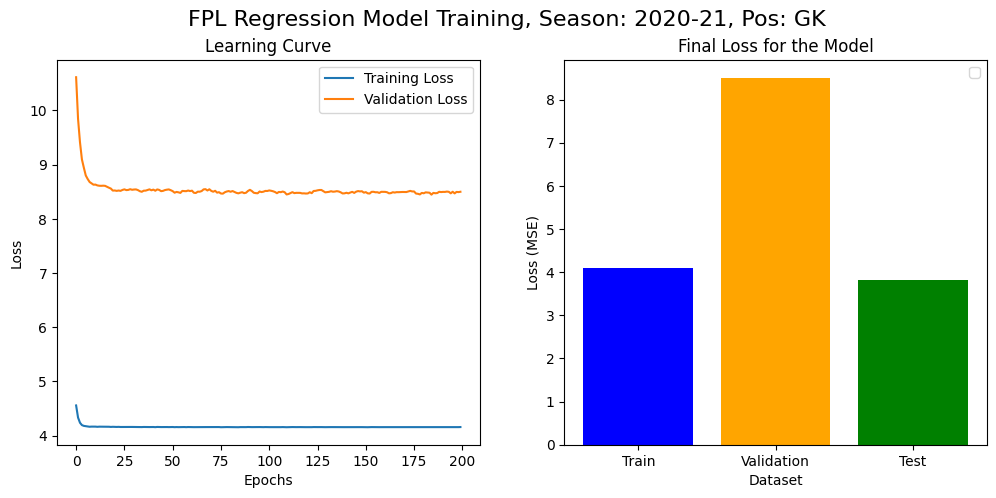

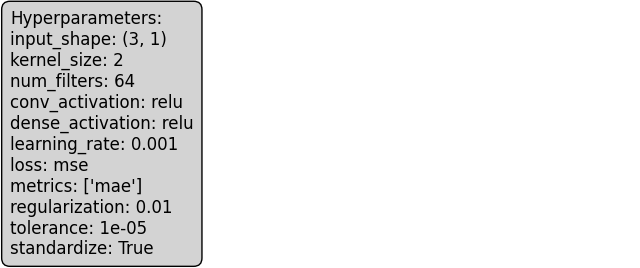

(<keras.src.engine.sequential.Sequential at 0x2c1e52df0>,
 <keras.src.callbacks.History at 0x2c31b7670>)

In [3]:
STANDARD_NUM_FEATURES = ['minutes', 'goals_scored', 'assists', 'goals_conceded',
                          'clean_sheets', 'bps', 'yellow_cards', 'red_cards', 
                          'own_goals', 'saves', 'penalties_missed', 'penalties_saved',
                          'ict_index', 'total_points']
STANDARD_CAT_FEATURES = []

#tf.random.set_seed(229)
#np.random.seed(229)

DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'clean_data')

build_train_cnn(DATA_DIR,
                season = '2020-21', 
                position = 'GK', 
                window_size=3,
                kernel_size=2,
                num_filters=64,
                num_dense=64,
                batch_size = 32,
                epochs = 200,  
                drop_low_playtime = False,
                low_playtime_cutoff = 20,
                num_features = ['total_points'],
                cat_features = STANDARD_CAT_FEATURES, 
                conv_activation = 'relu',
                dense_activation = 'relu',
                learning_rate= 0.001,
                loss = 'mse',
                metrics = ['mae'],
                verbose = True,
                regularization = 0.01, 
                tolerance = 1e-5,   #not currently used, disabled early stopping
                plot = True, 
                standardize= True)

## GridSearch for Best Model

In [8]:
from mlpremier.cnn.experiment import gridsearch_cnn

gridsearch_cnn(epochs=75)

Epoch 1/75
48/48 [==============================] - 0s 2ms/step - loss: 4.9844 - mae: 1.3149 - val_loss: 7.0722 - val_mae: 1.6702
Epoch 2/75
48/48 [==============================] - 0s 820us/step - loss: 4.8278 - mae: 1.4306 - val_loss: 7.0986 - val_mae: 1.6841
Epoch 3/75
48/48 [==============================] - 0s 720us/step - loss: 4.8238 - mae: 1.4343 - val_loss: 7.1133 - val_mae: 1.6748
Epoch 4/75
48/48 [==============================] - 0s 721us/step - loss: 4.8249 - mae: 1.4283 - val_loss: 7.0354 - val_mae: 1.6807
Epoch 5/75
48/48 [==============================] - 0s 718us/step - loss: 4.8184 - mae: 1.4285 - val_loss: 7.0876 - val_mae: 1.6849
Epoch 6/75
48/48 [==============================] - 0s 724us/step - loss: 4.8184 - mae: 1.4356 - val_loss: 7.2205 - val_mae: 1.6758
Epoch 7/75
48/48 [==============================] - 0s 668us/step - loss: 4.8217 - mae: 1.4331 - val_loss: 7.2224 - val_mae: 1.6536
Epoch 8/75
48/48 [==============================] - 0s 652us/step - loss: 4.82

/Users/danielfrees/Desktop/mlpremier/mlpremier/cnn/../../mlpremier/cnn/evaluate.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([param_data], columns=log_df.columns)], ignore_index=True)


Epoch 1/75
46/46 [==============================] - 0s 2ms/step - loss: 6.0184 - mae: 1.5856 - val_loss: 4.7592 - val_mae: 1.5557
Epoch 2/75
46/46 [==============================] - 0s 860us/step - loss: 5.8070 - mae: 1.6996 - val_loss: 4.7968 - val_mae: 1.4910
Epoch 3/75
46/46 [==============================] - 0s 790us/step - loss: 5.8192 - mae: 1.6778 - val_loss: 4.7549 - val_mae: 1.5391
Epoch 4/75
46/46 [==============================] - 0s 779us/step - loss: 5.8132 - mae: 1.6943 - val_loss: 4.6769 - val_mae: 1.4663
Epoch 5/75
46/46 [==============================] - 0s 771us/step - loss: 5.8184 - mae: 1.6676 - val_loss: 4.7921 - val_mae: 1.5835
Epoch 6/75
46/46 [==============================] - 0s 781us/step - loss: 5.8245 - mae: 1.6963 - val_loss: 4.7465 - val_mae: 1.5214
Epoch 7/75
46/46 [==============================] - 0s 717us/step - loss: 5.8269 - mae: 1.6860 - val_loss: 4.6945 - val_mae: 1.5021
Epoch 8/75
46/46 [==============================] - 0s 738us/step - loss: 5.81

## PieceWise Testing

## Generate the CNN Data

In [ ]:
df, features_df = generate_cnn_data(data_dir=os.path.join(os.getcwd(), '..', 'data', 'clean_data'), 
                         season='2020-21', 
                         position='GK', 
                         window_size=6,
                         verbose = True)
df.loc[0,'features']


======= Generating CNN Data for Season: 2020-21, Position: GK =======
Dropping Players with Avg. Playtime < 35...

Total players of type GK = 80.
60 players dropped due to low average playtime.
Generated windowed dataframe for CNN of shape: (632, 3).
Generated combined features dataframe for preprocessing of shape: (752, 14).

========== Done Generating CNN Data ==========



,minutes,goals_scored,assists,goals_conceded,clean_sheets,bps,yellow_cards,red_cards,own_goals,saves,penalties_missed,penalties_saved,ict_index,total_points
0,90,0,0,2,0,12,0,0,0,2,0,0,1.8,1
1,90,0,0,1,0,10,0,0,0,1,0,0,1.1,2
2,90,0,0,1,0,26,0,0,0,7,0,0,5.2,4
3,90,0,0,2,0,13,0,0,0,3,0,0,2.1,2
4,90,0,0,1,0,18,0,0,0,5,0,0,2.8,3
5,90,0,0,2,0,14,0,0,0,3,0,0,2.2,2


In [ ]:
df.head(5)

,name,features,target
0,Aaron Ramsdale,minutes goals_scored assists goals_conce...,4
1,Aaron Ramsdale,minutes goals_scored assists goals_conce...,2
2,Aaron Ramsdale,minutes goals_scored assists goals_conce...,2
3,Aaron Ramsdale,minutes goals_scored assists goals_conce...,3
4,Aaron Ramsdale,minutes goals_scored assists goals_conce...,1


In [ ]:
df.tail(5)

,name,features,target
627,Kasper Schmeichel,minutes goals_scored assists goals_conc...,2
628,Kasper Schmeichel,minutes goals_scored assists goals_conc...,0
629,Kasper Schmeichel,minutes goals_scored assists goals_conc...,2
630,Kasper Schmeichel,minutes goals_scored assists goals_conc...,2
631,Kasper Schmeichel,minutes goals_scored assists goals_conc...,-2


In [ ]:
df.loc[0,'features'].shape

(6, 14)

In [ ]:
df.loc[0,'features']

,minutes,goals_scored,assists,goals_conceded,clean_sheets,bps,yellow_cards,red_cards,own_goals,saves,penalties_missed,penalties_saved,ict_index,total_points
0,90,0,0,2,0,12,0,0,0,2,0,0,1.8,1
1,90,0,0,1,0,10,0,0,0,1,0,0,1.1,2
2,90,0,0,1,0,26,0,0,0,7,0,0,5.2,4
3,90,0,0,2,0,13,0,0,0,3,0,0,2.1,2
4,90,0,0,1,0,18,0,0,0,5,0,0,2.8,3
5,90,0,0,2,0,14,0,0,0,3,0,0,2.2,2


In [ ]:
features_df

,minutes,goals_scored,assists,goals_conceded,clean_sheets,bps,yellow_cards,red_cards,own_goals,saves,penalties_missed,penalties_saved,ict_index,total_points
0,90,0,0,2,0,12,0,0,0,2,0,0,1.8,1
1,90,0,0,1,0,10,0,0,0,1,0,0,1.1,2
2,90,0,0,1,0,26,0,0,0,7,0,0,5.2,4
3,90,0,0,2,0,13,0,0,0,3,0,0,2.1,2
4,90,0,0,1,0,18,0,0,0,5,0,0,2.8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,90,0,0,1,0,11,0,0,0,2,0,0,1.4,2
34,90,0,0,4,0,12,0,0,0,2,0,0,1.4,0
35,90,0,0,1,0,7,0,0,0,0,0,0,0.3,2
36,90,0,0,2,0,17,0,0,0,4,0,0,3.7,2


In [ ]:
features_df.describe()

,minutes,goals_scored,assists,goals_conceded,clean_sheets,bps,yellow_cards,red_cards,own_goals,saves,penalties_missed,penalties_saved,ict_index,total_points
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.00000,752.0,752.000000,752.000000,752.000000
mean,80.575798,0.001330,0.002660,1.188830,0.271277,16.813830,0.033245,0.001330,0.003989,2.69016,0.0,0.014628,2.103324,3.441489
std,27.395259,0.036466,0.051537,1.278307,0.444914,9.168633,0.179394,0.036466,0.063077,2.04308,0.0,0.120137,1.486558,3.055942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,-2.000000
25%,90.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.000000,1.000000
50%,90.000000,0.000000,0.000000,1.000000,0.000000,16.000000,0.000000,0.000000,0.000000,2.00000,0.0,0.000000,2.000000,2.000000
75%,90.000000,0.000000,0.000000,2.000000,1.000000,23.000000,0.000000,0.000000,0.000000,4.00000,0.0,0.000000,3.025000,6.000000
max,90.000000,1.000000,1.000000,9.000000,1.000000,45.000000,1.000000,1.000000,1.000000,11.00000,0.0,1.000000,7.600000,15.000000


## Split & Preprocess CNN Data

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_preprocess_cnn_data(df, 
                                                            features_df,
                                                            standardize=False, 
                                                            verbose=True)

# Print shapes
#print("Expecting Shapes to be of (ex, window, ftr) where \n \tftr: ORGNL_FEATURE_SIZE + 19 (team dummies) + 19 (opponent_team dummies) = 58")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

========== Splitting CNN Data ==========

Shape of windowed_df: (632, 3)
Shape of a given window: (6, 14)
========== Preprocessing CNN Data ==========

No StandardScaler applied. standardize=False.
Transforming features using StandardScaler + OHE Pipeline.
========== Done Preprocessing CNN Data ==========

========== Done Splitting CNN Data ==========

X_train shape: (442, 6, 1)
y_train shape: (442,)
X_val shape: (96, 6, 1)
y_val shape: (96,)
X_test shape: (94, 6, 1)
y_test shape: (94,)


In [ ]:
X_train[0:2]

array([[[1],
        [2],
        [4],
        [2],
        [3],
        [2]],

       [[2],
        [4],
        [2],
        [3],
        [2],
        [4]]])

In [ ]:
y_train[0:2]

array([4, 2])